In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

In [25]:
# Preamble

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

from dataclasses import astuple

import os
from os.path import exists, join as pjoin, realpath
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve

#external
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T

#own
import mbt_util as M
import bbox
from src import img_util as G, mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS
from src.swisstopo import bbchsw, bbchsc, bbchse, bbchc, bbchn

In [4]:
def tree():
    """Return a tree of tuples representing the logger layout.
    Each tuple looks like ``('logger-name', <Logger>, [...])`` where the
    third element is a list of zero or more child tuples that share the
    same layout.
    """
    root = ('', logging.root, [])
    nodes = {}
    items = list(logging.root.manager.loggerDict.items())  # for Python 2 and 3
    items.sort()
    for name, logger in items:
        nodes[name] = node = (name, logger, [])
        i = name.rfind('.', 0, len(name) - 1)  # same formula used in `logging`
        if i == -1:
            parent = root
        else:
            parent = nodes[name[:i]]
        parent[2].append(node)
    return root

tree()

('',
 <RootLogger root (DEBUG)>,
 [('IPKernelApp', <Logger IPKernelApp (WARNING)>, []),
  ('PIL', <Logger PIL (INFO)>, [('PIL.Image', <Logger PIL.Image (INFO)>, [])]),
  ('asyncio', <Logger asyncio (DEBUG)>, []),
  ('concurrent',
   [('concurrent.futures', <Logger concurrent.futures (DEBUG)>, [])]),
  ('parso',
   [('parso.cache', <Logger parso.cache (DEBUG)>, []),
    ('parso.python',
     [('parso.python.diff', <Logger parso.python.diff (DEBUG)>, [])])]),
  ('pkg_resources',
   [('pkg_resources.extern',
     [('pkg_resources.extern.packaging',
       [('pkg_resources.extern.packaging.tags',
         <Logger pkg_resources.extern.packaging.tags (DEBUG)>,
         [])])])]),
  ('prompt_toolkit',
   [('prompt_toolkit.buffer', <Logger prompt_toolkit.buffer (DEBUG)>, [])]),
  ('tornado',
   <Logger tornado (DEBUG)>,
   [('tornado.access', <Logger tornado.access (DEBUG)>, []),
    ('tornado.application', <Logger tornado.application (DEBUG)>, []),
    ('tornado.general', <Logger tornado.gene

In [5]:
cdir = pjoin(NBROOT, '../data/sample_ch')
os.makedirs(cdir, exist_ok=True)
%cd $cdir

/home/me/code/eddy-geek/etopo/data/sample_ch



---

## WMTS download

I have cut this in 5 parts to keep size manageable

| id     | bounds |
| --     | --     |
| chsw   | AixB-Thun          |
| chsc   | Challand-Vuorz    |
| chse   | Morbegno-Resia    |
| chc    | Pontarlier-Pfunds |
| chn    | Morteau-Opfenbach |


In [22]:
print('    ', SS.bbchz10_extent.__str__(3))
for z in 9, 10:
    for mode in '-~+':
        print(f'{z:>2}', mode, SS.bbchz10_extent.snap_to_xyz(z, mode).__str__(3))


     3.900 44.370 13.360 48.720
 9 - 4.219 44.590 13.359 48.458
 9 ~ 4.219 44.590 13.359 48.922
 9 + 3.516 44.088 14.062 48.922
10 - 4.219 44.590 13.359 48.691
10 ~ 3.867 44.340 13.359 48.691
10 + 3.867 44.340 13.711 48.922


In [42]:
print('    ', SS.bbchz12_extent.__str__(3))
for z in 9, 10, 12:
    for mode in '-~+':
        print(f'{z:>2}', mode, SS.bbchz12_extent.snap_to_xyz(z, mode).__str__(3))

     5.590 45.461 10.880 47.814
 9 - 5.625 45.583 10.547 47.517
 9 ~ 5.625 45.583 10.547 47.990
 9 + 4.922 45.089 11.250 47.990
10 - 5.625 45.583 10.547 47.754
10 ~ 5.625 45.583 10.898 47.754
10 + 5.273 45.337 10.898 47.990
12 - 5.625 45.522 10.811 47.813
12 ~ 5.625 45.460 10.898 47.813
12 + 5.537 45.460 10.898 47.872


In [37]:
# Based on `explore-SwissTopo-2-api.ipynb` I wrote `bbox_to_mbt`
MD.bbox_to_mbt('chz9.mbtiles', SS.bbchz10, [9, 10], 'jpeg', SS.geturl_ch_downsampled)

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 520
Added 100 tiles in 12.1 + 0.001 + 0.019 seconds. Status: 100 / 520
Added 100 tiles in 15.2 + 0.001 + 0.009 seconds. Status: 200 / 520
Added 100 tiles in 14.9 + 0.001 + 0.021 seconds. Status: 300 / 520
Added 100 tiles in 16.0 + 0.001 + 0.008 seconds. Status: 400 / 520
Added 100 tiles in 13.7 + 0.000 + 0.010 seconds. Status: 500 / 520
Added 20 tiles in 3.6 + 0.0001 + 0.0022 seconds. Status: done!


In [43]:
M.mbt_info('mch.mbtiles')

'zoom = 9 16 ; n = 278727 ; bounds = 5.976563,45.706182,10.546877,47.04018 ; format = jpeg'

In [18]:
SS.bbchz12

BBox(w=3.955078125, s=44.40239182909391, e=13.359375, n=48.6909603909255)

In [20]:
SS.bbchz12

BBox(w=5.625, s=45.460130637921, e=10.810546875, n=47.81315451752767)

In [31]:
t = T.tile(SS.bbchz12.w, SS.bbchz12.s, 12)
t.x, (1 << 12) - t.y - 1

(2112, 2629)

In [36]:
# with M.cursor('mch.mbtiles') as dbc:
#     n = dbc.execute(
#         '''DELETE FROM tiles WHERE zoom_level=12 AND 
#            (tile_column <= ? OR tile_row <= ?)''', (t.x -1, (1 << 12) - t.y - 1)).fetchone()

In [41]:
t = T.tile(SS.bbchz12.e, SS.bbchz12.n, 12)
t.x, (1 << 12) - t.y - 1

(2171, 2668)

In [50]:
# with M.cursor('mch.mbtiles') as dbc:
#     n = dbc.execute(
#         '''DELETE FROM tiles WHERE zoom_level=12 AND 
#            (tile_column >= ? OR tile_row >= ?)''', (t.x - 1, (1 << 12) - (t.y -6) - 1))
#     print(dbc.rowcount)

2200


In [44]:
# Based on `explore-SwissTopo-2-api.ipynb` I wrote `bbox_to_mbt`
MD.bbox_to_mbt('mch.mbtiles', SS.bbchz12, [12], 'jpeg', SS.geturl_ch_downsampled)

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 7597
Added 100 tiles in 12.7 + 0.001 + 0.004 seconds. Status: 100 / 7597
Added 100 tiles in 14.2 + 0.001 + 0.000 seconds. Status: 200 / 7597
Added 100 tiles in 12.7 + 0.001 + 0.001 seconds. Status: 300 / 7597
Added 100 tiles in 12.4 + 0.001 + 0.002 seconds. Status: 400 / 7597
Added 100 tiles in 12.8 + 0.001 + 0.002 seconds. Status: 500 / 7597
Added 100 tiles in 13.7 + 0.001 + 0.001 seconds. Status: 600 / 7597
Added 100 tiles in 12.2 + 0.001 + 0.001 seconds. Status: 700 / 7597
Added 100 tiles in 14.4 + 0.001 + 0.002 seconds. Status: 800 / 7597
Added 100 tiles in 13.2 + 0.001 + 0.002 seconds. Status: 900 / 7597
Added 100 tiles in 15.7 + 0.001 + 0.001 seconds. Status: 1000 / 7597
Added 100 tiles in 15.2 + 0.000 + 0.001 seconds. Status: 1100 / 7597
Added 100 tiles in 15.7 + 0.001 + 0.001 seconds. Status: 1200 / 7597
Added 100 tiles in 13.8 + 0.001 + 0.007 seconds. Status: 1300 / 7597
Added 100 tiles in 14.8 + 0.001 + 0.017 seconds. 

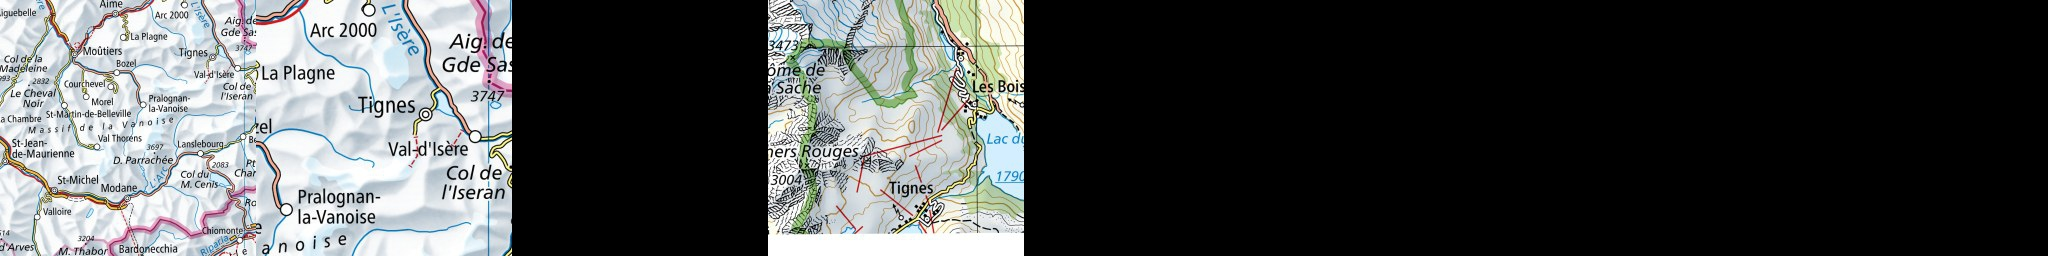

In [53]:
MY.tile_pyramid('tignes_mch.jpg', ll=bbox.lltignes, mbt='mch.mbtiles')
Image('tignes_mch.jpg')

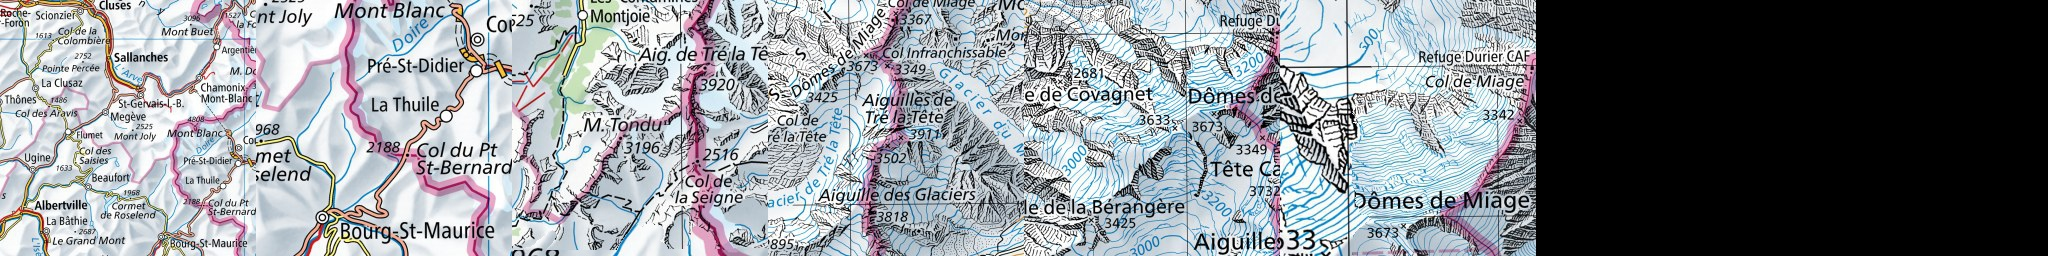

In [54]:
MY.tile_pyramid('miage_mch.jpg', ll=bbox.llmiage, mbt='mch.mbtiles')
Image('miage_mch.jpg')

In [55]:
M.mbt_info('mch.mbtiles')

'zoom = 9 16 ; n = 280691 ; bounds = 4.21875,44.37000,13.35938,48.45835 ; format = jpeg'

In [16]:
M.mbt_merge('chz9.mbtiles', dest='mch.mbtiles')

<< chz9 : zoom = 9 10 ; n = 520 ; bounds = 4.21875,44.590467181308846,13.359375,48.45835188280866 ; format = jpeg
>> mch : zoom = 9 16 ; n = 285697 ; bounds = 4.21875,44.37000,13.35938,48.45835 ; format = jpeg


In [6]:
M.update_mbt_meta('mch.mbtiles', name='SwissTopo mix-scale', bounds=SS.bbchz9.astuple(), desc=
'''Switzerland SwissTopo National Map, zoom 9-16. https://map.geo.admin.ch
Unlike the website, this is a downscaled version when possible (1 zoom level up for each layer).''')

In [ ]:
# !aws s3 cp --acl public-read ./mch.mbtiles s3://topo/

# Update z10-12 map *(2023)*

In [34]:
bbchz12_extent = SS.BBox(5.43, 45.40, 11.22, 48.14)
bbchz12 = bbchz12_extent.snap_to_xyz(z=12, mode='~')
bbchz12

BBox(w=5.44921875, s=45.398449976304086, e=11.25, n=48.16608541901253)

In [ ]:
from src import geometry as GY
GY.bbalps11

In [ ]:
MD.bbox_to_mbt('chz9.mbtiles', bbchz12, [9], 'jpeg', SS.geturl_ch_downsampled)


In [60]:
MD.bbox_to_mbt('chz9.mbtiles', SS.BBox(0.0,40.97,22.5,48.92), [9,10], 'jpeg', SS.geturl_ch_downsampled)


Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 2656
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/176.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/177.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/178.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/179.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/180.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/181.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.noscale/default/current/3857/9/256/182.jpeg
! 400 https://wmts100.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe-pk1000.nosca

In [63]:
bbz9 = SS.BBox(3.9, 44.37, 13.4, 48.7).snap_to_xyz(z=9, mode='-')
bbz9

BBox(w=4.21875, s=44.590467181308846, e=13.359375, n=48.45835188280866)

In [64]:
M.cut_to_lnglat('chz9.mbtiles', bb=M.LLBb(*bbz9))

Backing up source as: chz9.mbtiles
cut_to_lnglat chz9.bak.mbtiles -> chz9.mbtiles
9 10 10
z 9: +104 tiles: 262<x<274 327<y<334
z 10: +416 tiles: 524<x<549 654<y<669
Meta update {'bounds': '4.21875,44.59047,13.35938,48.45835',
 'center': '8.78906,46.52441,9',
 'maxzoom': 10,
 'minzoom': 9,
 'type': 'baselayer'}


In [35]:
from src import geometry as GY
MD.bbox_to_mbt('chz12.mbtiles', bbchz12, [10,11,12], 'jpeg', SS.geturl_ch_downsampled)

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 4032
Added 100 tiles in 15.8 + 0.001 + 0.012 seconds. Status: 100 / 4032
Added 100 tiles in 15.8 + 0.001 + 0.008 seconds. Status: 200 / 4032
Added 100 tiles in 15.6 + 0.000 + 0.003 seconds. Status: 300 / 4032
Added 100 tiles in 15.8 + 0.000 + 0.004 seconds. Status: 400 / 4032
Added 100 tiles in 16.4 + 0.000 + 0.006 seconds. Status: 500 / 4032
Added 100 tiles in 15.4 + 0.000 + 0.006 seconds. Status: 600 / 4032
Added 100 tiles in 16.0 + 0.000 + 0.006 seconds. Status: 700 / 4032
Added 100 tiles in 16.1 + 0.000 + 0.007 seconds. Status: 800 / 4032
Added 100 tiles in 15.8 + 0.000 + 0.006 seconds. Status: 900 / 4032
Added 100 tiles in 16.1 + 0.000 + 0.006 seconds. Status: 1000 / 4032
Added 100 tiles in 16.4 + 0.000 + 0.006 seconds. Status: 1100 / 4032
Added 100 tiles in 18.1 + 0.000 + 0.006 seconds. Status: 1200 / 4032
Added 100 tiles in 16.3 + 0.000 + 0.007 seconds. Status: 1300 / 4032
Added 100 tiles in 17.0 + 0.000 + 0.008 seconds. 

### Clean incomplete tiles from chz12 download

In [ ]:
with M.cursor('chz12.mbtiles') as dbc:
    z = 10
    dbc.execute(f'''
        DELETE FROM main.tiles
        WHERE zoom_level = {z}
        AND (
            tile_row = (SELECT MIN(tile_row)
                        FROM main.tiles WHERE zoom_level = {z})
        OR
            tile_column = (SELECT MIN(tile_column)
                        FROM main.tiles WHERE zoom_level = {z})
        )''')

In [ ]:
with M.cursor('/opt/map/mapdata/mbtiles/chz12.mbtiles') as dbc:
    z = 11
    dbc.execute(f'''
        DELETE FROM main.tiles
        WHERE zoom_level = {z}
        AND (
            tile_row = (SELECT MIN(tile_row)
                        FROM main.tiles WHERE zoom_level = {z})
        OR
            tile_column = (SELECT MIN(tile_column)
                        FROM main.tiles WHERE zoom_level = {z})
        )''')

# Add alps11-CHNE zone (2023)

In [23]:
bbch11 = bbox.BBox(8.789,47.041,9.77,47.517)
MD.bbox_to_mbt('ch11.mbtiles', bbch11, [13,14,15], 'jpeg', SS.geturl_ch_downsampled)

Added 0 tiles in 0.0 + 0.000 + 0.000 seconds. Status: 0 / 7680
Added 100 tiles in 807.4 + 0.001 + 0.016 seconds. Status: 100 / 7680
Added 100 tiles in 16.7 + 0.001 + 0.009 seconds. Status: 200 / 7680
Added 100 tiles in 16.2 + 0.001 + 0.010 seconds. Status: 300 / 7680
Added 100 tiles in 15.9 + 0.001 + 0.012 seconds. Status: 400 / 7680
Added 100 tiles in 16.6 + 0.000 + 0.011 seconds. Status: 500 / 7680
Added 100 tiles in 16.3 + 0.001 + 0.025 seconds. Status: 600 / 7680
Added 100 tiles in 17.4 + 0.001 + 0.013 seconds. Status: 700 / 7680
Added 100 tiles in 16.5 + 0.001 + 0.010 seconds. Status: 800 / 7680
Added 100 tiles in 16.2 + 0.001 + 0.011 seconds. Status: 900 / 7680
Added 100 tiles in 17.2 + 0.001 + 0.012 seconds. Status: 1000 / 7680
Added 100 tiles in 17.1 + 0.001 + 0.012 seconds. Status: 1100 / 7680
Added 100 tiles in 18.0 + 0.000 + 0.012 seconds. Status: 1200 / 7680
Added 100 tiles in 17.7 + 0.001 + 0.006 seconds. Status: 1300 / 7680
Added 100 tiles in 17.3 + 0.000 + 0.011 seconds.

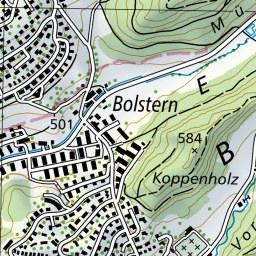

In [12]:
im = urlopen(SS.geturl_ch_downsampled(15,17183,11463), timeout=2).read()
display(Image(im))